#Data Analysis - Machine Learning Template
 - Supervised ML : Train and Prediction/Classification
   - Source : https://github.com/tooget/DataAnalysis-MachineLearning-Template
   - 기본적 용어 정의 : [Google 머신러닝 단기집중과정](https://developers.google.com/machine-learning/crash-course/?hl=ko)

- - -

** Template Flow**
 - Google Drive 마운트
 - 학습용 데이터셋(csv) 로드 : `df_train`
 - 예측용 데이터셋(csv) 로드 : `df_test`  (=Prediction Target 컬럼 없음, 풀어야 할 문제)
 - 학습용 , 예측용 데이터넷 먼징
 - 학습용 데이터 분할 : 학습 데이터셋, 테스트 데이터셋, (옵션)검증 데이터셋
 - 예측 모델 학습 및 스코어링
 - 예측 데이터 생성
 - 예측 데이터 저장

---

**분석환경**
 - Google Colaboratory
 - Google Drive
 - Python 3.6.6
 - google-colab==0.0.1a1
 - pandas==0.22.0

## Mount Google Drive to load/save files

In [0]:
# !python --version
# !pip --version
# !pip install pandas_profiling
# !pip freeze
# !pip install graphviz



---


**Google Drive 연결**

In [0]:
# google.colab 의 drive 라이브러리 이용
from google.colab import drive
drive.mount('/content/gdrive')

# !ls ./gdrive/M* -al

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).




---


**Directory 지정**

In [0]:
import os

cwd = os.getcwd()
print('Current Working Directory:', cwd)

gdrive = os.path.join(os.getcwd(), 'gdrive', 'My Drive')
print('Check Connection with Google Drive:', gdrive)

dataPath = os.path.join(gdrive, '<google-drive-path1>', '<google-drive-path2>')
print('Created dataPath :', dataPath)

Current Working Directory: /content
Check Connection with Google Drive: /content/gdrive/My Drive
Created dataPath : /content/gdrive/My Drive/<google-drive-path1>/<google-drive-path2>


## Load Dataset

### Dataset Merging

#### Dataset import

In [0]:
def readCSVtoDataframe(path, filename, list_of_dateparse):
    
    import pandas as pd
    
    dataframe = pd.read_csv(
                        f'{path}/{filename}',
                        #Need to check manually
                        #Trouble Shooting : 파싱되지 않는 컬럼 'Preserve_regist_date'(dtype=object)
                        parse_dates = list_of_dateparse,
                )
    
    return dataframe

In [0]:
df_train = readCSVtoDataframe(
                            dataPath,
                           '<training-dataset>.csv',
                            ['<date-column1>', '<date-column2>', '<date-column3>', '<date-column4>']
           )

- - -
`df_train` 전체 크기 확인

In [0]:
df_train.shape
# df_train.columns
# df_train.head()
# df_train.tail()

#### Dataset Problem

- - -
**<training-dataset.csv>**과 **<predicting-target-dataset.csv>**를 사전에 통합하여 고려하지 않으면 아래와 같은 문제가 발생함.
 - Categorical Features : One-Hot Encoding 중간변환시 데이터 매핑을 별도로 저장하여 적용해야 함.
 - Continous Features : 정규화 mean, std 값의 대표성이 어떠한지 (데이터가 수십~수백만 건 정도로 많다면 별 문제는 없겠지만)

- - -
_수천만건 이상 많아지면 sparkml : https://www.slideshare.net/sanghoonlee982/machine-learning-deep-learnig-with-spark_

 - AWSKRUG DataScience 모임 발표하신 분 이야기로는, "수십GB 이상 데이터, 명사 One-Hot Encoding 후 Feature 8만개 이상 ML도 가볍게 가능함"

#### Dataset Problem Solving

In [0]:
df_test = readCSVtoDataframe(
                            dataPath,
                           '<test-dataset>.csv',
                            ['<date-column1>', '<date-column2>', '<date-column3>', '<date-column4>']
           )

In [0]:
df_test.shape
# df_test.columns
# df_test.head()
# df_test.tail()

In [0]:
def concatDataframes(list_of_dataframes):
    import pandas as pd
    dataframe = pd.concat(list_of_dataframes, axis=0)
    return dataframe

- - -
전체 데이터셋 파악을 위해 임시로  `df_train` + `df_test` 함.

In [0]:
df_train_test = concatDataframes( [df_train, df_test] )

In [0]:
df_train_test.shape
# df_train_test.columns
# df_train_test.head()
# df_train_test.tail()a

- - -
 - 데이터 먼징 이후 **dataframe[:len(df_train)]** 을 train으로 재사용할 수 있음
 - 데이터 먼징 이후 **dataframe[len(df_train):]** 을 test으로 재사용할 수 있음

In [0]:
# df_train_test[:len(df_train)]
# df_train_test[len(df_train):]

## Munge Dataset/Features

###Features Creation & Deletion

- - -
**Feature 조정 함수**
 - 가설을 세운 새로운 Label 생성
 - 가설을 세운 새로운 Feature 생성
 - 가설에 불필요하다고 판단한 Feature 제외
 - 기본적 결측값 보정

In [0]:
def featureCreation(dataframe):

    import pandas as pd
    from math import log
    import numpy as np

    # 예측할 feature(=label) 생성
    # -------------------------------------------------
    # 샘플1 : 비율 예측 (특성 교차, Continous Variable)
    dataframe['<feature1_feature2_rate>'] = dataframe['<feature1>'] / dataframe['<feature2>']
    # -------------------------------------------------
    # 샘플2 : Binary 예측 (비닝, Categorical Variable)
    dataframe['<feature1_100_0_1>'] = dataframe['<feature1>'].apply( lambda x: 0 if x < 100 else 1 )    
    # -------------------------------------------------
    
    
    # 학습 feature 생성/정제
    # -------------------------------------------------
    # 샘플1 : 값의 유무를 새로운 Boolean Type으로 feature 생성 (표현 변환, Categorical Variable)
    dataframe['<feature1_exist>'] = dataframe['<feature1>'].notna()
    # -------------------------------------------------
    # 샘플2 : 경과기간(연도) feature 생성 (특성교차, 표현 변환, Continous Variable)
    dataframe['<feature_duration_year>'] = (dataframe['<feature_end_date>'] - dataframe['<feature_start_date>']) / np.timedelta64(1, 'Y')
    # -------------------------------------------------
    # 샘플3 : 도메인을 로그 스케일로 변환하여 feature 생성
    dataframe['<feature1_logscale>'] = dataframe['<feature1>'].apply( lambda x: 0 if x <= 0 else log(x) )  #0값 존재함.
    # -------------------------------------------------
    

    # 결측값 보정
    # -------------------------------------------------
    # 샘플1 : 날짜가 1111-11-11인 값을 중위값으로 치환하여 보정
    dataframe['<datetype_feature1>'] = pd.to_datetime( dataframe['<datetype_feature1>'], errors='coerce' )
    dataframe['<datetype_feature1>'] = dataframe [ dataframe['<datetype_feature1>'].isna() == False ]['<datetype_feature1>'].quantile(.5)
    # -------------------------------------------------
    # 샘플2 : feature 정제시 0으로 나눌 때 발생하는 무한대 값(numpy.inf)을 0으로 치환
    dataframe = dataframe.replace([np.inf, -np.inf], 0)
    # -------------------------------------------------
    # 샘플3 : 비어 있는 값을 0으로 치환
    dataframe = dataframe.fillna(0)
    # -------------------------------------------------

    
    #학습할 feature에서 제외
    dataframe = dataframe.drop([

        # 예측 레이블은 사전에 숙지하고 나중에 조정함
        # '<feature1_feature2_rate>',
        # '<feature1_100_0_1>',
        
        # 학습 대상 제외 혹은 무시(Heuristic)
        '<feature_obiously_not_related>', 
        '<feature_too_much_category_values>', # One-Hot Encoding으로 따로 처리 필요
        '<feature_sentences>',                #정제 가능한 Categorical Variable로 치환후 One-Hot Encoding 필요
        
    ], axis='columns')
    
    return dataframe

- - -
`df_train`과 `df_test`을 합쳐서 정제하니 간단함

In [0]:
df_train_test = featureCreation(df_train_test)

In [0]:
# df_train_test [ df_train_test['<feature_need_to_check>'].isna() == True ].count()

###Categorical & Continous Variables Control

- - -
각 feature가 Categorial variable인지 Countinous variable인지 대략적으로 판단해 두어야, 반복되는 feature 조정 작업이 용이해짐

- - -
**Categorical Features 구분 함수**
 - Heuristic Filter Sample1 : Unique Value < 500 
 - Heuristic Filter Sample2 : Keyword `rate`, `date`, `year` Exception From feature name
 > 가설 예시 : 한 feature에 고유한 값이 500개 미만이고, feature의 명칭에 특정 키워드가 들어있지 않으면 연속변수일 것 같음

In [0]:
def tagCategoricalFeatures(dataframe):

    import pandas as pd
    
    #초기 
    df_categorical_features = pd.DataFrame({
                                    'Feature_name':list(dataframe.columns),
                                    'N_Unique':[dataframe[x].nunique() for x in dataframe.columns]
                              }).sort_values(by=['N_Unique']).reset_index(drop=True)
    df_categorical_features['Categorical'] = False

    #Heuristic Filter1 : Unique Value < 500
    #Heuristic Filter2 : Mannual (Keyword)
    features_Categorical = df_categorical_features[
                                (df_categorical_features['N_Unique'] < 500) & \
                                (df_categorical_features['Feature_name'].str.contains(r'rate|date|year') == False)
                           ].index
    features_Categorical = list(features_Categorical)
    
    df_categorical_features['Categorical'].loc[features_Categorical,] = True
    
    return df_categorical_features

In [0]:
df_categorical_features = tagCategoricalFeatures(df_train_test)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
# df_categorical_features

# #N of deleted categorical features
# len(df_categorical_features[ df_categorical_features['Categorical'] == True ])
# #N of created One-Hot binary features
# df_categorical_features[ df_categorical_features['Categorical'] == True ]['N_Unique'].sum()
# #N of Continous features
# len(df_categorical_features[ df_categorical_features['Categorical'] == False ])

- - -
**데이터 먼징 함수**
 - Categorical Features : One-Hot Encoding
 - Continous Features : Standardize with mean, std
   - **이 부분은 Continous Variable 의 분포, 모집단의 정규성 등을 별도로 판단 후 적용이 필요함.**
   - 함부로 쓰면 스코어/예측률이 매우 저조해짐

In [0]:
def changeDtypeAndOneHotEncodingAndStandardize(dataframe, df_categorical_features):

    import pandas as pd
    
    # Categorical Features만 추출하여 One-Hot Encoding 및 정규화 처리의 기준으로 삼음.
    categorical_feature_names = list( df_categorical_features[ df_categorical_features['Categorical'] == True ]['Feature_name'] )
    # print('categorical_feature_names : ', categorical_feature_names)

    # 정규화 전 Continous features의 요약통계를 보전함. 비교 확인 용
    df_describe = dataframe.describe()
    
    for feature_name in dataframe.columns:
        if feature_name not in categorical_feature_names:
            # convert Dtype to float64
            dataframe[feature_name] = dataframe[feature_name].astype('float64')
            # Standardize float values
            mean = dataframe[feature_name].mean()
            std = dataframe[feature_name].std()
            dataframe[feature_name] = dataframe[feature_name].apply( lambda x: (x - mean) / std )
            # print('feature_name : ', feature_name, f', dtype converted to float64. mean={mean}, std={std}')
        else:
            # convert Dtype to category
            dataframe[feature_name] = dataframe[feature_name].astype('category')
            # print('feature_name : ', feature_name, ', dtype converted to category')
    # One-Hot Encoding categorical values, 원 column은 모두 삭제됨.
    dataframe = pd.get_dummies(dataframe)
    
    return dataframe, df_describe

In [0]:
df_train_test, df_train_test_desc = changeDtypeAndOneHotEncodingAndStandardize(df_train_test, df_categorical_features)

In [0]:
# df_train_test.describe()

- - -
### pandas_profiling
Dataframe 전체의 요약 통계를 한방에 해결하는 라이브러리, 정규화 후 비교하는 등 요긴하게 쓰임
 - HTML 출력을 만들어내서 약간 오래 걸림

In [0]:
# import pandas_profiling
# pandas_profiling.ProfileReport(df_train)

###Dataset Splitting

- - -
- 위에서 학습 데이터셋 + 예측 대상 데이터셋을 합쳐서 먼징했으니, 다시 분리함
- 이는 `df_train`과 `df_test`의 모든 Countinous feature가 같은 분포를 가지고 있다고 가정한 상태이므로,
> _**두 데이터셋의 Continous feature들이 다른 분포를 보일 경우 별도로 정제해야 함! **_

In [0]:
splitter = len(df_train)
df_train = df_train_test[:splitter]
df_test = df_train_test[splitter:]

여기까지 하면 데이터 정제는 끝.
이제는 Machine Learning 알고리즘을 적용하여 학습 및 예측하면 됨.
> 결과가 좋지 않으면 다시 **featureCreation** 함수와 **changeDtypeAndOneHotEncodingAndStandardize** 함수로 이동하시길..

## Training : GradientBoosingRegressor

- - -
 - Tip1 : Machine Learning 알고리즘 중 여러 알고리즘을 거듭하여 최종 결과물을 나타내는 류([앙상블](https://haandol.github.io/2017/02/06/ensemble-bagging-boosting.html)) 중 Kaggle 등에 많이 쓰이는 XGBoost
 - Tip2 : Hyperparameter Tuning을 위한 grid_search (그 외 여러가지)
   > - Hyperparameter Tuning 과정 자체를 학습하여 parameter optimization을 하는 방법 : **["Practical Bayesian Optimization of Machine
Learning Algorithms"]**(https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf)
   > - 관련 라이브러리 : https://github.com/JasperSnoek/spearmint

### XBGRegressor Hyperparameter tuning sample
- - -
-                     'n_estimators': [300, 400, 500, 600],
                    'max_depth': [1],
                    'learning_rate': [0.04, 0.05, 0.06],
                    'seed': [None],
                    'gamma': [0, 0.01, 0.02],
                    'reg_lambda': [0, 0.025, 0.05],
                    'reg_alpha': [0, 0.025, 0.05],
                    'min_child_weight': [1, 2, 3],
> - Best score: 0.312718
Best parameters set:
	gamma: 0
	learning_rate: 0.06
	max_depth: 1
	min_child_weight: 1
	n_estimators: 600
	reg_alpha: 0.025
	reg_lambda: 0
	seed: None
Select Done..., Time Cost: 1153
RMSE : 0.029792
R2 Score : 0.303385

###GradientBoostingRegressor Hyperparameter tuning sample
- - -
-                     'loss': ['huber'],
                    'learning_rate': [0.1074, 0.1075, 0.106, 0.6],
                    'n_estimators': [555, 560, 565, 700],
                    'max_depth': [6, 7],
                    'max_features': ['sqrt'],
> - Best score: 0.343281
Best parameters set:
	learning_rate: 0.1074
	loss: 'huber'
	max_depth: 6
	max_features: 'sqrt'
	n_estimators: 555
Select Done..., Time Cost: 759
RMSE : 0.028290
R2 Score : 0.331792

- - -
데이터 먼징하면서 세팅해놓은 label feature 후보, 학습대상 feature 중에, 실제 학습할 대상 feature를 지정함
 - 그 때 그 떄 바꿔가면서 학습하기 좋게
 - Google Colaboratory면 단순한 파일 복제 & 실행으로 심플한 분산학습 환경 구축이 됨!

In [0]:
label_candidates = [
                    '<feature1_feature2_rate>',
                    '<feature1_100_0_1>',
                   ]

label_selection = '<feature1_100_0_1>'

In [0]:
feature_selection = list(df_train.drop(label_candidates, axis='columns').columns)

- - -
손실함수, 의미있는 최대 feature수 등을 사전에 지정하여 여러 케이스(grid)를 설정함.
 > Hyperparameter tuning을 위한 **grid_search** 함수에 이용됨
- MSE, Huber 등 손실함수 참고 : https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0

In [0]:
grid_parameters = {
                    'loss': ['huber'],   # 손실함수 지정
                    'learning_rate': [0.10735, 0.10740, 0.10745, 0.01, 0.001],
                    'n_estimators': [550, 555, 560, 600],
                    'max_depth': [6, 8],
                    'max_features': ['sqrt'],
                    'alpha': [0.7, 0.8, 0.9]
                  }

In [0]:
def trainXGBRegressor(df_train_dataset, label_selection, feature_selection, grid_parameters):
    
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.metrics import mean_squared_error, r2_score
    from multiprocessing import cpu_count
    from matplotlib import pyplot as plt
    import datetime
    import numpy as np
    
    idx_columnsForY = label_selection
    df_y = df_train_dataset[idx_columnsForY]
    
    idx_columnsForX = feature_selection
    df_x = df_train_dataset[feature_selection]
    
    print('Select Model...')
    start_time  = datetime.datetime.now()
    
    # 학습할 데이터셋의 3할을 평가를 위한 테스트셋으로 분할해 둠.(직접 학습 안함)
    test_size = 0.3
    X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=test_size)

    from sklearn.ensemble import GradientBoostingRegressor

    # 학습할 알고리즘 지정
    model = GradientBoostingRegressor()
    parameters = grid_parameters
    # 지정한 알고리즘을 세팅한 parameter grid로 각각 학습을 진행함.
    grid_search = GridSearchCV(
                        estimator=model,
                        param_grid=parameters,
                        cv=10,                # 각 parameter grid set 마다 10번씩 반복 학습함.
                        n_jobs=cpu_count(),   # cpu 코어수 만큼 병렬처리 학습
                        verbose=10,           # 10이면 학습 진행 내용이 거의 실시간으로 출력됨.
                  )

    print("parameters:")
    print(parameters)
    grid_search.fit(X_train, y_train)

    # 학습 목적이 Classification인지 Regression인지 구분하여 시각화 및 결과출력이 필요함.
    # 지금은 Regression : RMSE, R2 score
    print("Best score: %0.6f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters=grid_search.best_estimator_.get_params()

    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

    end_time = datetime.datetime.now()
    print( 'Select Done..., Time Cost: %d' % ((end_time - start_time).seconds) )

    _model = GradientBoostingRegressor(**best_parameters)
    _model.fit(X_train, y_train)
    
    y_pred = _model.predict(X_test)
    print( 'RMSE : %0.6f' % mean_squared_error(y_test, y_pred) )
    print( 'R2 Score : %0.6f' % r2_score(y_test, y_pred) )
    
    # #############################################################################
    # Plot training deviance
    # compute test set deviance
    test_score = np.zeros((best_parameters['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(_model.staged_predict(X_test)):
        test_score[i] = _model.loss_(y_test, y_pred)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Deviance')
    plt.plot(np.arange(best_parameters['n_estimators']) + 1, _model.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(np.arange(best_parameters['n_estimators']) + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')

    # #############################################################################
    # Plot feature importance
    feature_importance = _model.feature_importances_
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    idx_columnsForX = np.array(idx_columnsForX)
    plt.yticks(pos, idx_columnsForX[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    return grid_search.best_score_, best_parameters, _model

Select Model...
parameters:
{'loss': ['huber'], 'learning_rate': [0.10735, 0.1074, 0.10745, 0.01, 0.001], 'n_estimators': [550, 555, 560, 600], 'max_depth': [6, 8], 'max_features': ['sqrt'], 'alpha': [0.7, 0.8, 0.9]}
Fitting 10 folds for each of 120 candidates, totalling 1200 fits
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.3688444679961801, total=   3.9s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.23897015730638094, total=   3.9s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    4.0s


[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.38050108244341174, total=   4.5s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.38722208980174444, total=   4.6s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 


[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    8.6s


[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.17537255281956535, total=   4.5s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.22152167537999745, total=   4.7s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.39223571721157446, total=   4.5s
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.3485491950784052, total=   4.6s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning

[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   22.4s


[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.43751205140409144, total=   4.5s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.27458505910045716, total=   4.6s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.3753082860996567, total=   4.6s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.37152306225980614, total=   4.6s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   31.8s


[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.24729580438194954, total=   4.6s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.1522611763138555, total=   4.5s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.33842711525673586, total=   4.6s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.3939843875914231, total=   4.6s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_

[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   50.1s


[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.20938620925264984, total=   4.6s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.32428033598321127, total=   4.6s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.44371191852824443, total=   4.7s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.16539366602108252, total=   4.6s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learnin

[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  1.1min


[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.22881938434930327, total=   4.6s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.3616835083075419, total=   4.6s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.41043794679587975, total=   4.9s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.333356566143199, total=   4.9s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_r

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  1.5min


[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.4167469721496061, total=   4.9s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.21322448967158802, total=   4.9s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.3552918798494451, total=   4.8s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.438102872403143, total=   4.9s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_ra

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.8min


[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.3164277291958345, total=   5.0s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.40420722081906507, total=   5.1s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.24020880834612168, total=   5.0s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.35982975575130727, total=   5.0s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning

[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:  2.3min


[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555, score=0.2666025408584256, total=   5.0s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555, score=0.40431623331896355, total=   5.1s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.3953962558767906, total=   5.1s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.2939204667077956, total=   5.0s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_r

[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:  2.8min


[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.2308363353222096, total=   5.1s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.38446036263684114, total=   5.1s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.39618108737158364, total=   5.1s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.2832551168785772, total=   5.1s
[CV] alpha=0.7, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_

[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:  3.3min


[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.269369096805243, total=   4.6s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.3823403076036035, total=   4.6s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.38255560096539365, total=   4.6s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.23013869962701572, total=   4.6s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.10

[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:  3.8min


[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.16719095562229402, total=   4.7s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.15515013154296386, total=   4.5s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.37972083088657893, total=   4.5s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.41301082044488524, total=   4.6s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0

[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:  4.4min


[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.34338462050378726, total=   4.6s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.3999509864462334, total=   4.9s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.19424269308557973, total=   4.9s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.39121285113887105, total=   4.9s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.

[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:  5.0min


[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.16742498164556852, total=   5.0s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.18742895506091695, total=   5.5s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.3259193644148055, total=   5.1s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.3853122819685057, total=   5.1s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.1

[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:  5.8min


[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.29012257668228114, total=   5.1s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.4082811704552368, total=   5.1s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.352014619019945, total=   5.2s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.1894263542348643, total=   5.1s
[CV] alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.107

[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:  6.5min


[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.23620743082638496, total=   5.1s
[CV] alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.4133055748076773, total=   5.0s
[CV] alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.3772192292583103, total=   4.6s
[CV] alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.262613849868649, total=   4.5s
[CV] alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate

[Parallel(n_jobs=2)]: Done 177 tasks      | elapsed:  7.2min


[CV]  alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.3995201963806602, total=   4.7s
[CV] alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.2181496922614908, total=   4.5s
[CV] alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.37782832357157287, total=   4.7s
[CV] alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.4162746534079007, total=   4.5s
[CV] alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_r

[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  8.0min


[CV]  alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.31102014013681856, total=   5.0s
[CV] alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.4181933807816184, total=   4.9s
[CV] alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.2250539088320479, total=   5.0s
[CV] alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.36589141218699467, total=   4.9s
[CV] alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_

[Parallel(n_jobs=2)]: Done 217 tasks      | elapsed:  8.9min


[CV]  alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555, score=0.3703301557178934, total=   5.2s
[CV] alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555, score=0.2787049387804895, total=   5.2s
[CV] alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555, score=0.39459818516337053, total=   5.1s
[CV] alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.39296389819554167, total=   5.0s
[CV] alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_

[Parallel(n_jobs=2)]: Done 238 tasks      | elapsed:  9.8min


[CV]  alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.23341915644502684, total=   5.1s
[CV] alpha=0.7, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.39077110315857, total=   5.1s
[CV] alpha=0.7, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.4530622314888175, total=   5.0s
[CV] alpha=0.7, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.3026461451846413, total=   4.9s
[CV] alpha=0.7, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.01, loss=huber

[Parallel(n_jobs=2)]: Done 261 tasks      | elapsed: 10.8min


[CV]  alpha=0.7, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.2929760292846667, total=   5.0s
[CV] alpha=0.7, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.37386389865537617, total=   5.0s
[CV] alpha=0.7, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.3691338259095086, total=   4.9s
[CV] alpha=0.7, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.21313585483823982, total=   5.1s
[CV] alpha=0.7, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.7, learning_rate=0.01, loss=huber, m

[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed: 11.9min


[CV]  alpha=0.7, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.2305146330647082, total=   9.9s
[CV] alpha=0.7, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.21971119592192612, total=   9.8s
[CV] alpha=0.7, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.3824266254686113, total=   9.8s
[CV] alpha=0.7, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.4151350251627175, total=   9.9s
[CV] alpha=0.7, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.01, loss=huber, ma

[Parallel(n_jobs=2)]: Done 309 tasks      | elapsed: 14.1min


[CV]  alpha=0.7, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.29021619749872607, total=   9.8s
[CV] alpha=0.7, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.3071189951226082, total=  10.2s
[CV] alpha=0.7, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.4301221050877801, total=  10.6s
[CV] alpha=0.7, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.35852066047871395, total=  10.2s
[CV] alpha=0.7, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.01, loss=huber, m

[Parallel(n_jobs=2)]: Done 334 tasks      | elapsed: 15.6min


[CV]  alpha=0.7, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.13024617491822632, total=   5.4s
[CV] alpha=0.7, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.12157044168863085, total=   5.5s
[CV] alpha=0.7, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.22928970171280305, total=   5.4s
[CV] alpha=0.7, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.20094309531585142, total=   5.6s
[CV] alpha=0.7, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.7, learning_rate=0.001, lo

[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed: 17.0min


[CV]  alpha=0.7, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.17461110372224076, total=  11.4s
[CV] alpha=0.7, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.19437876989140235, total=  11.0s
[CV] alpha=0.7, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.23423574050477203, total=  11.3s
[CV] alpha=0.7, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.13520412199872733, total=  11.1s
[CV] alpha=0.7, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.7, learning_rate=0.001, lo

[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed: 19.5min


[CV]  alpha=0.7, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.19794987406338738, total=  11.3s
[CV] alpha=0.7, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.2077828197091468, total=  11.2s
[CV] alpha=0.7, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.25772335985008266, total=  12.2s
[CV] alpha=0.7, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.18210523459330885, total=  12.4s
[CV] alpha=0.7, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.7, learning_rate=0.001, los

[Parallel(n_jobs=2)]: Done 417 tasks      | elapsed: 21.4min


[CV]  alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.4232297485960172, total=   4.7s
[CV] alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.19174372848673116, total=   4.8s
[CV] alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.42922480684278785, total=   4.6s
[CV] alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.4191883020374887, total=   4.8s
[CV] alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.8, learning_

[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 22.6min


[CV]  alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.29566418814064177, total=   5.5s
[CV] alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.39472234007440243, total=   5.5s
[CV] alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.23243838395011854, total=   5.5s
[CV] alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.42126092438521967, total=   5.6s
[CV] alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.8, learnin

[Parallel(n_jobs=2)]: Done 477 tasks      | elapsed: 24.1min


[CV]  alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.3160863776401843, total=   5.5s
[CV] alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.21285771178495583, total=   5.6s
[CV] alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.3743865025033192, total=   5.5s
[CV] alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.41323170661740927, total=   4.7s
[CV] alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate

[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed: 25.3min


[CV]  alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.2348613021084981, total=   4.8s
[CV] alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.35407019703861087, total=   4.7s
[CV] alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.3282110164284848, total=   5.0s
[CV] alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.29019523862676044, total=   5.1s
[CV] alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.8, learning_rate=0.1

[Parallel(n_jobs=2)]: Done 541 tasks      | elapsed: 26.8min


[CV]  alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.22963470843902486, total=   5.6s
[CV] alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.3820084002310903, total=   5.6s
[CV] alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.42626642239025353, total=   5.6s
[CV] alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.25084785433705536, total=   5.5s
[CV] alpha=0.8, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.8, learning_rate=0.

[Parallel(n_jobs=2)]: Done 574 tasks      | elapsed: 28.3min


[CV]  alpha=0.8, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.15599500963008162, total=   4.8s
[CV] alpha=0.8, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.8, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.2053244694987082, total=   4.7s
[CV] alpha=0.8, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.8, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.3655448260517544, total=   4.7s
[CV] alpha=0.8, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.8, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.4170421351309634, total=   4.7s
[CV] alpha=0.8, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.8, learning_r

[Parallel(n_jobs=2)]: Done 609 tasks      | elapsed: 29.8min


[CV]  alpha=0.8, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.4371982387738201, total=   5.5s
[CV] alpha=0.8, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.8, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555, score=0.3322068050734367, total=   5.4s
[CV] alpha=0.8, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.8, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555, score=0.30264040594888264, total=   5.6s
[CV] alpha=0.8, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.8, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555, score=0.36976983257935825, total=   5.6s
[CV] alpha=0.8, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.8, learning_

[Parallel(n_jobs=2)]: Done 644 tasks      | elapsed: 31.4min


[CV]  alpha=0.8, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.224007638514523, total=   5.0s
[CV] alpha=0.8, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.22436464772768328, total=   4.9s
[CV] alpha=0.8, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.364528610307579, total=   4.9s
[CV] alpha=0.8, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.4157142150289792, total=   4.9s
[CV] alpha=0.8, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.01, loss=huber, max_

[Parallel(n_jobs=2)]: Done 681 tasks      | elapsed: 33.0min


[CV]  alpha=0.8, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.3779623088720677, total=   9.7s
[CV] alpha=0.8, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.39229890016770474, total=  10.3s
[CV] alpha=0.8, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.23890915690882275, total=   9.9s
[CV] alpha=0.8, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.21052616427843152, total=  10.2s
[CV] alpha=0.8, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.01, loss=huber, 

[Parallel(n_jobs=2)]: Done 718 tasks      | elapsed: 36.1min


[CV]  alpha=0.8, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.40300807867767857, total=  10.8s
[CV] alpha=0.8, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.28359125142947716, total=  10.9s
[CV] alpha=0.8, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.22776280335877522, total=   5.4s
[CV] alpha=0.8, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.15700047703583664, total=   5.4s
[CV] alpha=0.8, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.001, loss

[Parallel(n_jobs=2)]: Done 757 tasks      | elapsed: 38.0min


[CV]  alpha=0.8, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.2358465333955793, total=   5.8s
[CV] alpha=0.8, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.8, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.18929738298719612, total=   5.8s
[CV] alpha=0.8, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.19299876920315964, total=   5.9s
[CV] alpha=0.8, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.24409348644343698, total=  11.3s
[CV] alpha=0.8, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.001, los

[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 41.6min


[CV]  alpha=0.8, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.2480255944097265, total=  11.9s
[CV] alpha=0.8, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.8, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.22152045764177797, total=  12.4s
[CV] alpha=0.8, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.8, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.20876654323294663, total=  12.3s
[CV] alpha=0.9, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.8, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.2119578313679077, total=  12.1s
[CV] alpha=0.9, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.9, learning_rate=0.10735

[Parallel(n_jobs=2)]: Done 837 tasks      | elapsed: 43.6min


[CV]  alpha=0.9, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.39181863738801026, total=   5.2s
[CV] alpha=0.9, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.9, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.21413698983157825, total=   5.1s
[CV] alpha=0.9, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.9, learning_rate=0.10735, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.3759856858228213, total=   5.3s
[CV] alpha=0.9, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.9, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.3659721929914037, total=   6.0s
[CV] alpha=0.9, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.9, learning_

[Parallel(n_jobs=2)]: Done 878 tasks      | elapsed: 45.7min


[CV]  alpha=0.9, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.1946476687923161, total=   6.1s
[CV] alpha=0.9, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.9, learning_rate=0.10735, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.4134641833647508, total=   6.2s
[CV] alpha=0.9, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.9, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.39251049728904097, total=   4.8s
[CV] alpha=0.9, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.9, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.28868100282457876, total=   4.9s
[CV] alpha=0.9, learning_rate=0.1074, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.9, learning_rate=0

[Parallel(n_jobs=2)]: Done 921 tasks      | elapsed: 47.5min


[CV]  alpha=0.9, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.2873780096875914, total=   6.0s
[CV] alpha=0.9, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.9, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.40800545036865055, total=   6.2s
[CV] alpha=0.9, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.9, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.3458123784227807, total=   6.0s
[CV] alpha=0.9, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.9, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.1456680347313365, total=   6.1s
[CV] alpha=0.9, learning_rate=0.1074, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.9, learning_rate=0.10

[Parallel(n_jobs=2)]: Done 964 tasks      | elapsed: 49.7min


[CV]  alpha=0.9, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.1498583036321276, total=   4.8s
[CV] alpha=0.9, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.9, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.17892022304048738, total=   4.8s
[CV] alpha=0.9, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.9, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.345606670420616, total=   4.9s
[CV] alpha=0.9, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.9, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550, score=0.387415629008021, total=   4.8s
[CV] alpha=0.9, learning_rate=0.10745, loss=huber, max_depth=6, max_features=sqrt, n_estimators=550 
[CV]  alpha=0.9, learning_rat

[Parallel(n_jobs=2)]: Done 1009 tasks      | elapsed: 51.7min


[CV]  alpha=0.9, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=550, score=0.42700243708851154, total=   6.4s
[CV] alpha=0.9, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.9, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555, score=0.4325910044624946, total=   6.2s
[CV] alpha=0.9, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.9, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555, score=0.25389846181035425, total=   6.2s
[CV] alpha=0.9, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.9, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555, score=0.3382525772217958, total=   6.1s
[CV] alpha=0.9, learning_rate=0.10745, loss=huber, max_depth=8, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.9, learning_

[Parallel(n_jobs=2)]: Done 1054 tasks      | elapsed: 53.8min


[CV]  alpha=0.9, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.2321547173992352, total=   5.1s
[CV] alpha=0.9, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.9, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.2321804806455856, total=   5.0s
[CV] alpha=0.9, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.9, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.3798969911065935, total=   5.0s
[CV] alpha=0.9, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.9, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555, score=0.4120345130361359, total=   4.9s
[CV] alpha=0.9, learning_rate=0.01, loss=huber, max_depth=6, max_features=sqrt, n_estimators=555 
[CV]  alpha=0.9, learning_rate=0.01, loss=huber, max

[Parallel(n_jobs=2)]: Done 1101 tasks      | elapsed: 56.8min


[CV]  alpha=0.9, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.384878339979125, total=  10.7s
[CV] alpha=0.9, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.9, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.4055427610516714, total=  10.8s
[CV] alpha=0.9, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.9, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.24142867489826011, total=  10.3s
[CV] alpha=0.9, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.9, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560, score=0.2552572115323395, total=  10.5s
[CV] alpha=0.9, learning_rate=0.01, loss=huber, max_depth=8, max_features=sqrt, n_estimators=560 
[CV]  alpha=0.9, learning_rate=0.01, loss=huber, max

[Parallel(n_jobs=2)]: Done 1148 tasks      | elapsed: 59.7min


[CV]  alpha=0.9, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.1812398912573464, total=   5.4s
[CV] alpha=0.9, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.9, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=560, score=0.18456135752213232, total=   5.5s
[CV] alpha=0.9, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.9, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.24249095807033283, total=   5.9s
[CV] alpha=0.9, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.9, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600, score=0.166823420770985, total=   5.8s
[CV] alpha=0.9, learning_rate=0.001, loss=huber, max_depth=6, max_features=sqrt, n_estimators=600 
[CV]  alpha=0.9, learning_rate=0.001, loss=

[Parallel(n_jobs=2)]: Done 1197 tasks      | elapsed: 64.0min


[CV]  alpha=0.9, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.21920411398783535, total=  12.1s
[CV]  alpha=0.9, learning_rate=0.001, loss=huber, max_depth=8, max_features=sqrt, n_estimators=600, score=0.21006855061910823, total=  12.4s


[Parallel(n_jobs=2)]: Done 1200 out of 1200 | elapsed: 64.2min finished


Best score: 0.353058
Best parameters set:
	alpha: 0.9
	learning_rate: 0.01
	loss: 'huber'
	max_depth: 8
	max_features: 'sqrt'
	n_estimators: 560
Select Done..., Time Cost: 3859
RMSE : 0.019027
R2 Score : 0.508220


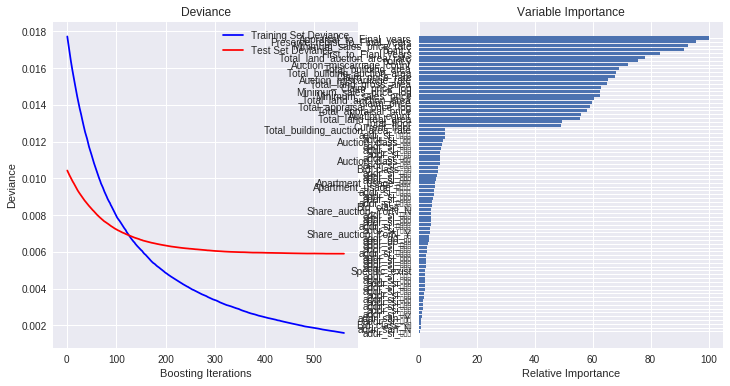

In [0]:
best_score, best_parameters, model1 = trainXGBRegressor(df_train, label_selection, feature_selection, grid_parameters)

In [0]:
best_score

0.35305753351587726

- - -
**grid_search** 결과 찾아낸 최적 parameter : `best_parameters`

In [0]:
best_parameters

{'alpha': 0.9,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.01,
 'loss': 'huber',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 560,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

- - -
**grid_search** 결과 찾아낸 최적 예측 모델 : `model1`

In [0]:
model1

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='huber', max_depth=8,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=560,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [0]:
import pandas as pd

df_feature_importance = pd.DataFrame({
                            'feature_importances_': model1.feature_importances_,
                            'feature_name': feature_selection
                        })

- - -
함수 내부에 시각화 코드도 있지만, 표로 다시 한 번 정확하게 feature 우선순위를 검증함
 - [feature selection theory archive](https://machinelearningmastery.com/an-introduction-to-feature-selection)
 - [feature_importances_ について調べてみた](https://nomoto-eriko.hatenablog.com/entry/2018/06/06/101729)
 - [다중공선성](https://datascienceschool.net/view-notebook/36176e580d124612a376cf29872cd2f0/)

In [0]:
df_feature_importance.sort_values(by='feature_importances_')

## Create & Save a Prediction Data file

- - -
`df_test` --(입력)--> `model1` --(출력)--> label feature 예상값을 추출함.

In [0]:
def predictTestDataset(model, df_test_dataset, label_selection, feature_selection):
    
    idx_columnsForY = label_selection
    df_y = df_test_dataset[idx_columnsForY]
    
    idx_columnsForX = feature_selection
    df_x = df_test_dataset[idx_columnsForX]
    
    y_pred = model.predict(df_x)
    
    return y_pred

In [0]:
Test_pred_label = predictTestDataset(model1, df_test)

- - -
먼징 과정에 Countinous features 중 정규화가 있었다면 다시 원복해야 됨
 - 이 경우도, `df_train`와 `df_test`가 동일한 분포임을 가정하고 정규화를 해제하는 과정이므로,
 > **`df_train`와 `df_test`의 분포를 다르게 가정하여 처리하였다면 별도의 통계량을 저장하여 원복하여야 함!**

In [0]:
Test_pred_label = Test_pred_label * df_train_test_desc[label_selection]['std'] + df_train_test_desc[label_selection]['mean']

In [0]:
df_submission = pd.DataFrame({
                        '<label_feature_name>': Test_pred_label
                })

- - -
예측 내용을 저장하고, Competition에서 정의한 제출 파일을 저장하여, 제출하면 끝

In [0]:
submissionPath = os.path.join(gdrive, '<google-drive-path1>', '<google-drive-path2>')

df_submission.to_csv(
        f'{submissionPath}/<submission_file_name>.csv',
        sep=',',
        encoding='utf-8',
        index=False,            # 자동 생성되는 index 순번은 저장하지 않음
        index_label=False
)